In [15]:
from datetime import datetime
from typing import List
import requests as req
from statistics import mean
from pandas import DataFrame
import matplotlib.pyplot as plt


In [33]:
class ChartCollectorAPI():
    def __init__(self):
        self.charts={}
        
    
    def get_chart(self,symbol:str,charts:List[str]=None,range:str="1mo") -> list:
        
        # Lits of available API keys (formed in dictionnary)
        apiKeys = [{'x-api-key': "LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP"},{'x-api-key': "x0lGuGoAQMvr9Uweu7y62z0TwB0rHIx8eSxPwsV4"},{'x-api-key': "mTd2MNVwEe3WFgj5PQ66Tbpq0CyeP8Q7ESjpmYZ2"},]
        
        # We try each and every key defined inside apiKeys (the list of keys)
        for apiKey in apiKeys:
            
            # We tell the user which key is currently used to make the request
            print(f"API Key used :{apiKey['x-api-key']}")
            
            # The header is the api key as a dict ({'x-api-key': "XXX"}) it is defined by Yahoo Finance
            headers = apiKey
        
            # Here is the start of the url used for the request
            url = f"https://yfapi.net/v8/finance/chart/{symbol}?"
            
            # If we defined charts variable (list of symbols) the we concatenate them to the url respecting the Yahoo API documentation (adding %2C between each symbol)
            if charts:
                # We add "comparisons=" to the url (defined by the Yahoo API documentation) it allows us to collect more symbols data
                url += "comparisons="
                for asset in charts:
                    url+= asset
                    if asset != (len(charts) - 1):
                        url+="%2C"
                url += "&"
                
                
            # Here we add the end of the url defining the correct range, region, interval between close values, language and specify the event (how to understand and separate every comparison symbol)
            url+=f"range={range}&region=US&interval=1d&lang=en&events=div%2Csplit"
            
            # We send the GET request to the Yahoo API
            response = req.request("GET", url, headers=headers)
            
            try:
                # We try to collect the response. If there is an error, it means that the request failed (most of the time because of request exceeding the limit)
                response = response.json()["chart"]["result"][0]
                
                # We collect timestamps 
                timesamps = response["timestamp"]
                # We get the reference graph (close values)
                reference = response["indicators"]["quote"][0]["close"]
                
                # Adding reference chart
                if symbol not in self.charts and None not in reference:
                    print(symbol)
                    self.charts[symbol]=[{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, reference)]
                
                
                if charts:
                    comparison = response["comparisons"]
                    # Adding the comparisons charts
                    for value in comparison:
                        symbol = value["symbol"]
                        print(symbol)
                        if symbol not in self.charts and None not in value["close"]:
                            self.charts[symbol]=[{"date":datetime.fromtimestamp(int(timestamp)), "close":close} for timestamp, close in zip(timesamps, value["close"])]
                        elif symbol in self.charts:
                            print (f"{symbol} already loaded")
                        else:
                            print(f"{symbol} contains None values")
                            
                
                return # If there is no exception raised, it means we managed to get the data

                
            
            except Exception as error:
                print(response.json())
                print("Trying with another api key...") # We continue the for loop
                
        print("There is no valid API key remaining ! ") # If there is no element in the for loop, we exit and tell the user the data hasn't been loaded
                
        
        
    """
    Methode pour charger des graphiques présenregistrés
    """
    def loading(self,charts):
        self.charts=charts
        
    """Methode qui sauvegarde les differents graphiques de comparaisons des différents actifs passés dans une liste en parametre
    Print dans la console les differentes distances en fonction de l'algorithme utilisé.
    """
    def resultats_rapports(self,actif_reference,charts) -> dict:
        results = {}
        
        
        
        chart_reference_datas = [value['close'] for value in charts[actif_reference]] #Recup prix de cloture
        
        
        # Les données mensuelles sont de taille 21 normalement 
        data_length = 21
        
        date_reference = charts[actif_reference][-data_length*2]['date'] #Recup la première date du graphique reference (WIP)
        
        # Le graphique de reference correspond a l'avant dernier mois (les 21 jours en commencant il y a 42 jours)
        chart_reference = chart_reference_datas[-data_length*2:-data_length]
        
        # Les données correspondant à ce qu'il s'est passé après soit les 21 derniers jours
        chart_reference_current_data = chart_reference_datas[-data_length:]
        
        # On le compare aux autres graphiques
        for actif_comparaison in charts:
            if actif_comparaison != actif_reference:
                
                # On recupere les données de comparaison
                chart_comparison = [{"close":value['close'],"date":value['date']} for value in charts[actif_comparaison]]


                # On va réduire la fenetre des actifs de comparaison afin d'être au plus proche de notre strategie
                # On créé des sublists en décalant de un jour à chaque list suivante
                # On enleve le dernier mois et on garde les autres mois
                comparison_charts = [chart_comparison[:-data_length*2][x:x+data_length] for x in range(0, len(chart_comparison[:-data_length*2]))]
                

                # On va réduire la fenetre des actifs de comparaison afin d'être au plus proche de notre strategie
                # On créé des sublists en décalant de un jour à chaque list suivante
                # On enleve le premier mois et on garde les autres mois
                reality_charts = [chart_comparison[data_length-1:-data_length][x:x+data_length] for x in range(0, len(chart_comparison[data_length-1:-data_length]))]
                
                    
                # Comparison correspond à un mois en partant du premier jusqu'à l'avant dernier, et current correspond au mois d'apres
                for comparison,current_data in zip(comparison_charts,reality_charts): #Zip ==> parcourir deux listes en même temps même vitesse
                    
                    # Si les deux graphiques n'ont pas la meme taille cela implique que l'on n'a pas exactement 21 jours dans le mois
                    # Il faut s'assurer que les mois de données actuelles sont de mêmes tailles(les données du mois suivant )(pour verifier la prediction)
                    if (len(comparison) ==len(chart_reference) and len(current_data) ==len(chart_reference_current_data)):
                        try:
                            data_comparison = [value["close"] for value in comparison]
                            distance = self.distance_point_par_point_rapport_moyenne(chart_reference,data_comparison)["distance moyenne"]
                        except Exception as error:
                            print(f"Erreur sur le rapport moyenne {actif_reference} /  {actif_comparaison} : {error} ")
                            raise error

                        date_comparison = comparison[0]["date"] 
                        results[f"resultat pour comparaison date: {date_comparison} {actif_reference} /  {actif_comparaison} "] = { #f string, pour évaluer un string
                            "value":distance,
                            "actif_reference":actif_reference,
                            "actif_comparaison":actif_comparaison,
                            "chart_reference":chart_reference, # starts 42 values ago
                            "chart_comparison":data_comparison,
                            "current_data_comparison":[value["close"] for value in current_data],
                            "current_data_reference":chart_reference_current_data, # starts 21 values ago
                            "date_reference":date_reference,
                            "date_comparison":comparison[0]["date"],
                            }
     
        self.predictions=results
        return results                

    def distance_point_par_point_rapport_moyenne(self,chart_reference,chart_comparison):          
         # Adapte les amplitudes des courbes pour pouvoir les comparer
        
        ## On les ramene à 1 en faisant le rapport par rapport à leur moyenne
        try:
            rearange_reference = [value / mean(chart_reference) for value in chart_reference]
        except:
            print(chart_reference)
        try:
            rearange_comparison = [value / mean(chart_comparison) for value in chart_comparison]
        except:
            print(chart_comparison)

        # On calcule les differentes distances entre les points des deux courbes
        distances = [
            abs(rearange_reference[i] - rearange_comparison[i])
            for i in range(len(rearange_reference))
        ]

        return {"distance moyenne":round(sum(distances),2)}
    
    def predict(self,symbol:str):
        analysis = self.resultats_rapports(symbol,self.charts)
        lowest = 1

        for value in analysis:
            if (analysis[value]["value"]<lowest):
                lowest = analysis[value]["value"]
                best_choice = analysis[value]
        
        self.best_prediction = best_choice
        
        average_distance = best_choice["value"]
        current_data_comparison = best_choice["current_data_comparison"]
        current_data_reference = best_choice["current_data_reference"]
        chart_comparison = best_choice["chart_comparison"]
        chart_reference = best_choice["chart_reference"]

        prediction = current_data_comparison[len(current_data_comparison)-1]/mean(chart_comparison)*mean(chart_reference)

        print(f"L'actif qui ressemble le plus à {symbol} est {best_choice['actif_comparaison']} avec une distance de : {average_distance}")
        print(f"Premier jour du mois de l'actif de comparaison : {best_choice['date_comparison']}")
        print(f"Premier jour du mois de l'actif de reference : {best_choice['date_reference']}")
        print(f"Predicted price : {prediction}   / Real price : {current_data_reference[-1]}")
        print(f"Prediction error : {abs(1-prediction/current_data_reference[-1])*100}%")
        
    
    def plot_prediction(self,):
        if not self.best_prediction:
            print("There is no prediction to plot")
            return
            
        best_choice = self.best_prediction
        
        # On créé une nouvelle figure pour afficher le premier graphique
        Figure = plt.figure(figsize=(5,5), dpi=100)
        ax = Figure.add_subplot(111)
        ax.yaxis.label.set_color('red')

        # REFERENCE
        # On recupere les dates et les prix de l'actif 1
        dates = [index for index in range(len(best_choice["chart_reference"]))]
        prix = best_choice["current_data_reference"]

        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["actif_reference"]:prix},columns=[best_choice["actif_reference"],'dates'])

        # On regroupe les prix par dates
        df = df[['dates',best_choice["actif_reference"]]].groupby('dates').sum()

        # On affiche le dataframe
        df.plot(kind='line', legend=True, ax=ax, color='r')


        # On recupere les dates et les prix de l'actif 1 ce qui s'est reellement passé 
        prix = best_choice["chart_reference"]
        dates = [index for index in range(len(best_choice["chart_reference"]),len(best_choice["chart_reference"])+len(best_choice["chart_reference"]))]

        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["actif_reference"]:prix},columns=[best_choice["actif_reference"],'dates'])

        # On regroupe les prix par dates
        df = df[['dates',best_choice["actif_reference"]]].groupby('dates').sum()

        # On affiche le dataframe
        #df.plot(linestyle='dashed',kind='line', legend=True, ax=ax, color='r')



        # COMPARAISON
        # On decoupe les ordonnées en deux categories distinctes pour les visualiser correctement
        ax2 = ax.twinx()
        # On change la couleur du label des ordonnées
        ax2.yaxis.label.set_color('b')

        # On recupere les dates et les prix de l'actif 2
        prix = best_choice["chart_comparison"]
        # On recupere les dates et les prix de l'actif 2
        dates = [index for index in range(len(best_choice["chart_comparison"]))]
        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["actif_comparaison"]:prix},columns=[best_choice["actif_comparaison"],'dates'])
        # On regroupe les prix par dates
        df = df[['dates',best_choice["actif_comparaison"]]].groupby('dates').sum()
        # On affiche le dataframe
        df.plot(kind='line', legend=True, ax=ax2, color='b')


        # On recupere les dates et les prix de l'actif 2 ce qui s'est reellement passé 
        prix = best_choice["current_data_comparison"]
        dates = [index for index in range(len(best_choice["chart_reference"]),len(best_choice["chart_reference"])+len(best_choice["chart_reference"]))]
        # On crée un DataFrame pendant pour le plot plus facilement
        df = DataFrame({"dates":dates,best_choice["actif_comparaison"]:prix},columns=[best_choice["actif_comparaison"],'dates'])

        # On regroupe les prix par dates
        df = df[['dates',best_choice["actif_comparaison"]]].groupby('dates').sum()
        # On affiche le dataframe
        df.plot(linestyle='dashed',kind='line', legend=True, ax=ax2, color='b')

        ax.set_title('Prix des actions')

        Figure.show()
        
        ref = best_choice["actif_reference"]
        comp = best_choice["actif_comparaison"]
        try:
            Figure.savefig(f"prediction_for_{ref}_using_{comp}.png")
            print("Figure saved")
        except:
            print("Unable to save figure")


https://yfapi.net/v8/finance/chart/AAPL?comparisons=MSFT%2CAPPL&range=1mo&region=US&interval=1d&lang=en&events=div%2Csplit

On charge le plus grand nombre d'actifs possibles

In [17]:
assets =[  
"MULN",
"SNDL",
"DRCT",
"NIO",
"HYMC",
"AMD",
"TLRY",
"AMC",
"AAPL",
"ADGI",
"AKBA",
"BRQS",
"MU",
"CLVR",
"NAOV",
"SOFI",
"NILE",
"ITUB",
"IMPP",
"SWN",
"DIDI",
"NVDA",
"RMO",
"BEKE",
"HOOD",
"BAC",
"VALE",
"CEI",
"DNA",
"SXTC",
"PLTR",
"NLY",
"WFC",
"BBIG",
"PBR",
"TELL",
"AAL",
"BABA",
"MSFT",
"PFE",
"EDU",
"BBD",
"OXY",
"TME",
"NOK",
"FB",
"NLSN",
"CCL",
"INTC",
"TMC",
"VYNT",
"SIRI",
"CHWY",
"UBER",
"TEVA",
"XOM",
"IBN",
"LCID",
"RIG",
"ISIG",
"AFRM",
"KGC",
"ZSAN",
"MEIP",
"CSCW",
"RIVN",
"RBLX",
"TSLA",
"GERN",
"ZNGA",
"XELA",
"XPEV",
"FCEL",
"FAMI",
"CALA",
"DKNG",
"PLUG",
"LAC",
"WWR",
"MRO",
"SNAP",
"PYPL",
"KMI",
"CLF",
"CSCO",
"TWTR",
"PROG",
"PDD",
"CENN",
"NKLA",
"CMCSA"]

Maintenant que nous avons recuperé les données, on va regarder celle qui ressemble le plus à AAPL

Find the best match

In [18]:
Preloading = ChartCollectorAPI()

assets_lists = [assets[x:x+6] for x in range(0, len(assets), 6)]

for asset in assets_lists:
    print(asset)
    Preloading.get_chart(symbol=asset[0],charts=asset[1:],range="1y")

['MULN', 'SNDL', 'DRCT', 'NIO', 'HYMC', 'AMD']
API Key used :LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP
MULN
SNDL
HYMC
NIO
AMD
DRCT
DRCT contains None values
['TLRY', 'AMC', 'AAPL', 'ADGI', 'AKBA', 'BRQS']
API Key used :LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP
TLRY
AAPL
AMC
AKBA
ADGI
ADGI contains None values
BRQS
['MU', 'CLVR', 'NAOV', 'SOFI', 'NILE', 'ITUB']
API Key used :LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP
MU
NILE
SOFI
ITUB
CLVR
NAOV
['IMPP', 'SWN', 'DIDI', 'NVDA', 'RMO', 'BEKE']
API Key used :LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP
IMPP
NVDA
BEKE
RMO
DIDI
SWN
['HOOD', 'BAC', 'VALE', 'CEI', 'DNA', 'SXTC']
API Key used :LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP
HOOD
SXTC
BAC
CEI
DNA
VALE
['PLTR', 'NLY', 'WFC', 'BBIG', 'PBR', 'TELL']
API Key used :LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP
PLTR
BBIG
PBR
WFC
TELL
NLY
['AAL', 'BABA', 'MSFT', 'PFE', 'EDU', 'BBD']
API Key used :LgEsoJrl6o6my9g46Xk3y5hYcEEZJyhA3aknepFP
AAL
MSFT
BABA
BBD
EDU
PFE
['OXY', 'TME', 'NOK', 'FB', 'NLSN', 'CCL']
A

# On affiche les différents assets chargés

In [19]:
for asset in Preloading.charts:
    print(asset)

MULN
SNDL
HYMC
NIO
AMD
TLRY
AAPL
AMC
AKBA
BRQS
MU
NILE
SOFI
ITUB
CLVR
NAOV
IMPP
NVDA
BEKE
RMO
DIDI
SWN
HOOD
SXTC
BAC
CEI
DNA
VALE
PLTR
BBIG
PBR
WFC
TELL
NLY
AAL
MSFT
BABA
BBD
EDU
PFE
OXY
NOK
FB
TME
CCL
NLSN
INTC
VYNT
CHWY
SIRI
UBER
TEVA
RIG
LCID
IBN
XOM
ISIG
AFRM
KGC
MEIP
CSCW
ZSAN
RBLX
XPEV
TSLA
ZNGA
XELA
GERN
FCEL
DKNG
FAMI
PLUG
CALA
LAC
WWR
PYPL
KMI
MRO
SNAP
CLF
CSCO
PDD
NKLA
TWTR
CENN
PROG
CMCSA


L'actif qui ressemble le plus à AAPL est PYPL avec une distance de : 0.21
Premier jour du mois de l'actif de comparaison : 2021-09-15 15:30:00
Premier jour du mois de l'actif de reference : 2022-02-08 15:30:00
Predicted price : 127.83016008328256   / Real price : 172.38
Prediction error : 25.843972570319895%
Figure saved


/var/folders/k6/_mb6xsdj4_g0rcv39yljn9t00000gn/T/ipykernel_62634/73271335.py:278: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  Figure.show()


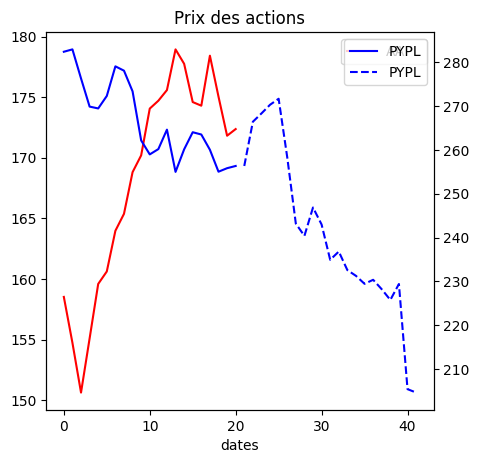

In [34]:
Analysis = ChartCollectorAPI()

Analysis.loading(Preloading.charts)
Analysis.predict("AAPL")

Analysis.plot_prediction()